### Fraud Analytics - C66890
### ASSIGNMENT 5
### Team Members
- Manikanta Vallepu - AI20BTECH11014
- Jarupula Saikumar - CS21BTECH11023
- Vignan Kota - CS21BTECH11029
- Sahil Chandra - CS20BTECH11033
- Kalala Abhinav - CO21BTECH11007

# Implementation

In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import Adam
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.impute import SimpleImputer
from scipy.stats import ks_2samp
from tqdm import tqdm

# Step 1: Preprocess the credit card dataset

# Load the dataset
credit_card_data = pd.read_csv("card_transaction.v1.csv")

# Convert 'Time' to numerical
credit_card_data['Time'] = credit_card_data['Time'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]) if ':' in x else 0)

# Remove '$' sign and convert 'Amount' to numerical
credit_card_data['Amount'] = credit_card_data['Amount'].str.replace('$', '').astype(float)

# Handle 'Errors?' column
credit_card_data['Errors?'] = credit_card_data['Errors?'].apply(lambda x: 0 if x == 'No' else 1)

# Normalize the numerical columns
scaler = MinMaxScaler()
numerical_cols = ['Year', 'Month','Amount', 'Day', 'Time']
credit_card_data[numerical_cols] = scaler.fit_transform(credit_card_data[numerical_cols])

# Use label encoding for categorical columns
le = LabelEncoder()
categorical_cols = ['User', 'Card', 'Use Chip', 'Merchant Name', 'Merchant City', 'Merchant State', 'Zip', 'MCC', 'Errors?', 'Is Fraud?']
for col in categorical_cols:
    credit_card_data[col] = le.fit_transform(credit_card_data[col])

# Normalize the entire DataFrame
scaler = MinMaxScaler()
credit_card_data = pd.DataFrame(scaler.fit_transform(credit_card_data), columns=credit_card_data.columns)

# Split the data into train and test sets
test_size = 0.2
test_mask = np.random.rand(len(credit_card_data)) < test_size
train_credit_card_data = credit_card_data[~test_mask].reset_index(drop=True)
test_credit_card_data = credit_card_data[test_mask].reset_index(drop=True)

combined_credit_card_data = pd.concat([train_credit_card_data, test_credit_card_data], ignore_index=True)

scaler = MinMaxScaler()
train_credit_card_data[numerical_cols] = scaler.fit_transform(train_credit_card_data[numerical_cols])
test_credit_card_data[numerical_cols] = scaler.transform(test_credit_card_data[numerical_cols])

# Combine numerical and label encoded categorical data
X_train_encoded = train_credit_card_data[numerical_cols + categorical_cols].values
X_test_encoded = test_credit_card_data[numerical_cols + categorical_cols].values


# Identify and handle NaN values in the input data
print("Number of NaN values in X_train_encoded:", np.sum(np.isnan(X_train_encoded)))
print("Number of NaN values in X_test_encoded:", np.sum(np.isnan(X_test_encoded)))

# Remove rows containing NaN values
nan_indices_train = np.isnan(X_train_encoded).any(axis=1)
nan_indices_test = np.isnan(X_test_encoded).any(axis=1)

X_train_cleaned = X_train_encoded[~nan_indices_train]
X_test_cleaned = X_test_encoded[~nan_indices_test]
imputer = SimpleImputer(strategy='mean')
X_train_encoded = imputer.fit_transform(X_train_encoded)
y_train = train_credit_card_data['Is Fraud?']
y_test = test_credit_card_data['Is Fraud?']

train_dataset = TensorDataset(torch.tensor(X_train_encoded, dtype=torch.float), torch.tensor(y_train.values, dtype=torch.float))
test_dataset = TensorDataset(torch.tensor(X_test_encoded, dtype=torch.float), torch.tensor(y_test.values, dtype=torch.float))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Number of NaN values in X_train_encoded: 1
Number of NaN values in X_test_encoded: 0


In [4]:
# Step 2: Design and train a Variational Autoencoder (VAE)

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim, num_categorical):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
           nn.Linear(input_dim, hidden_dim),
           nn.LeakyReLU(),
           nn.Dropout(0.5),
           nn.Linear(hidden_dim, hidden_dim),
           nn.LeakyReLU(),
           nn.Dropout(0.5),
           nn.Linear(hidden_dim, z_dim * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, input_dim)
        )
        self.num_categorical = num_categorical

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu, logvar = x[:, :x.size(1) // 2], x[:, x.size(1) // 2:]
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        recon_x[:, len(numerical_cols):] = torch.sigmoid(recon_x[:, len(numerical_cols):])  # Apply sigmoid to numerical columns
        return recon_x, mu, logvar
    
# Adjust loss function to handle one-hot encoded categorical columns
def loss_function(recon_x, x, mu, logvar, num_categorical):
    MSE = F.mse_loss(recon_x[:, :len(numerical_cols)], x[:, :len(numerical_cols)], reduction='sum')
    BCE_numerical = F.binary_cross_entropy(recon_x[:, len(numerical_cols):len(numerical_cols)+len(numerical_cols)], 
                                           x[:, len(numerical_cols):len(numerical_cols)+len(numerical_cols)], reduction='sum')
    BCE_categorical = F.binary_cross_entropy(recon_x[:, -num_categorical:], 
                                              x[:, -num_categorical:], reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    REG = 0.001 * sum(p.pow(2).sum() for p in model.parameters())
    return MSE + 0.5 * BCE_numerical + 0.5 * BCE_categorical + KLD + REG

input_dim = X_train_encoded.shape[1]
hidden_dim = 100
z_dim = 100
num_categorical = len(categorical_cols)
model = VAE(input_dim, hidden_dim, z_dim, num_categorical)

optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)


In [5]:
# Implement early stopping
best_loss = float('inf')
patience = 30
epochs_since_improvement = 0

def train(epoch):
    global best_loss, epochs_since_improvement
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch}')):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar, num_categorical)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f' Epoch: {epoch} Average train loss: {avg_loss:.4f}')

    # Evaluate on test set
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar, num_categorical)
            test_loss += loss.item()
    avg_test_loss = test_loss / len(test_loader.dataset)
    print(f' test loss: {avg_test_loss:.4f}')

    # Update learning rate scheduler
    scheduler.step(avg_test_loss)

    # Check for early stopping
    if avg_test_loss < best_loss:
        best_loss = avg_test_loss
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1

    if epochs_since_improvement >= patience:
        print(f"Early stopping after {epoch} epochs")
        return True

    return False

In [6]:
epochs = 1
for epoch in range(1, epochs + 1):
    if train(epoch):
        break

# Generate synthetic data
synthetic_data = []
with torch.no_grad():
    for i in tqdm(range(2000000 // 100), desc='Generating synthetic data'):
        sample = torch.randn(100, z_dim)
        synthetic_data.append(model.decoder(sample).cpu().numpy())
synthetic_data = np.concatenate(synthetic_data, axis=0)

# Convert synthetic to original scale and data types
synthetic_credit_card_data_numerical = pd.DataFrame(synthetic_data[:, :len(numerical_cols)], columns=numerical_cols)
synthetic_credit_card_data_numerical[numerical_cols] = scaler.inverse_transform(synthetic_credit_card_data_numerical[numerical_cols])

# Generate synthetic categorical data based on the mode of the real data
synthetic_credit_card_data_categorical = pd.DataFrame()
for col in categorical_cols:
    mode = credit_card_data[col].mode()[0]
    synthetic_credit_card_data_categorical[col] = np.full((2000000,), mode)

# Concatenate the synthetic numerical and categorical data
synthetic_credit_card_data = pd.concat([synthetic_credit_card_data_numerical, synthetic_credit_card_data_categorical], axis=1)


Epoch 1:   0%|          | 0/63867 [00:00<?, ?it/s]/home/vignan/.local/lib/python3.10/site-packages/torch/autograd/__init__.py:266: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 1: 100%|██████████| 63867/63867 [08:07<00:00, 131.09it/s]


 Epoch: 1 Average train loss: 4.5176
 test loss: 4.4947


Generating synthetic data: 100%|██████████| 20000/20000 [00:06<00:00, 2942.71it/s]


# Results

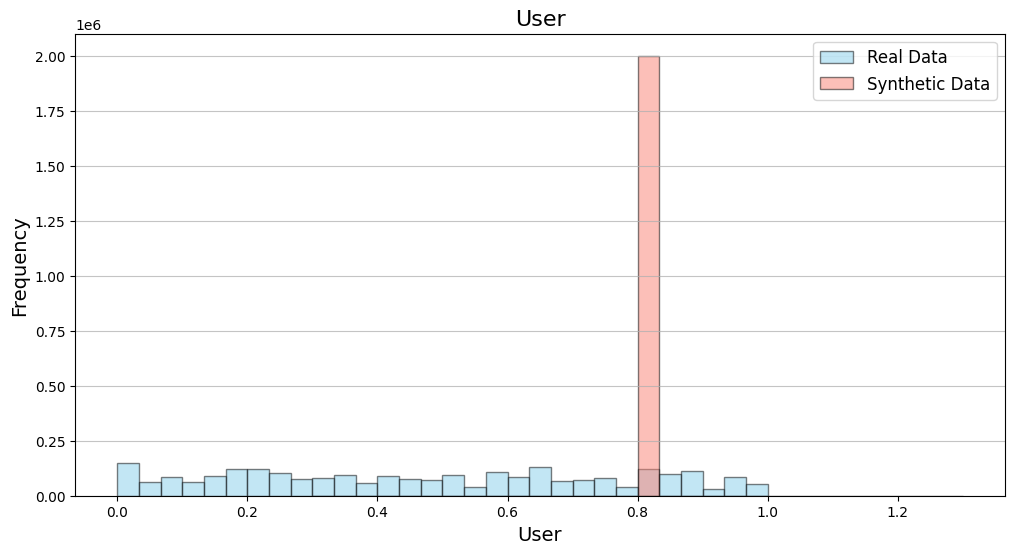

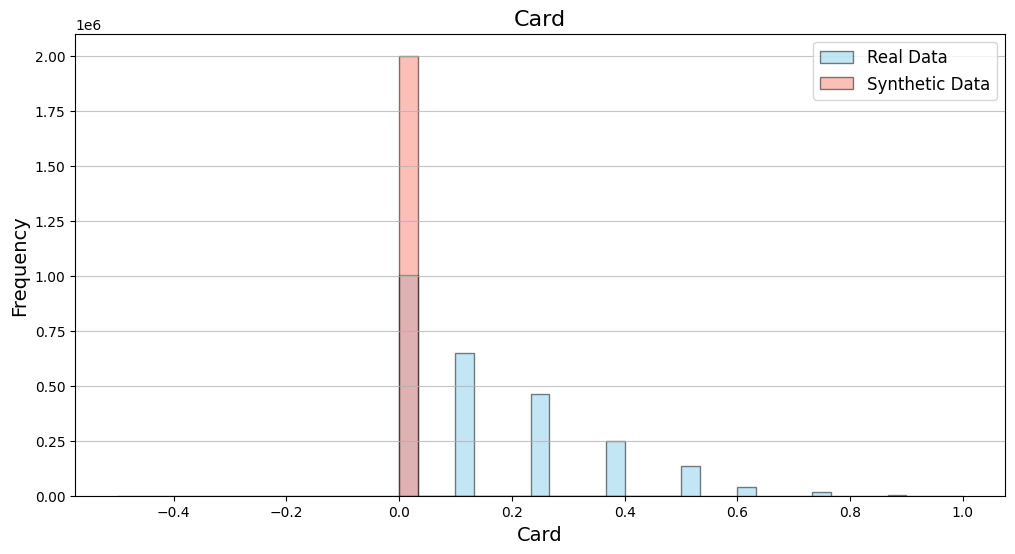

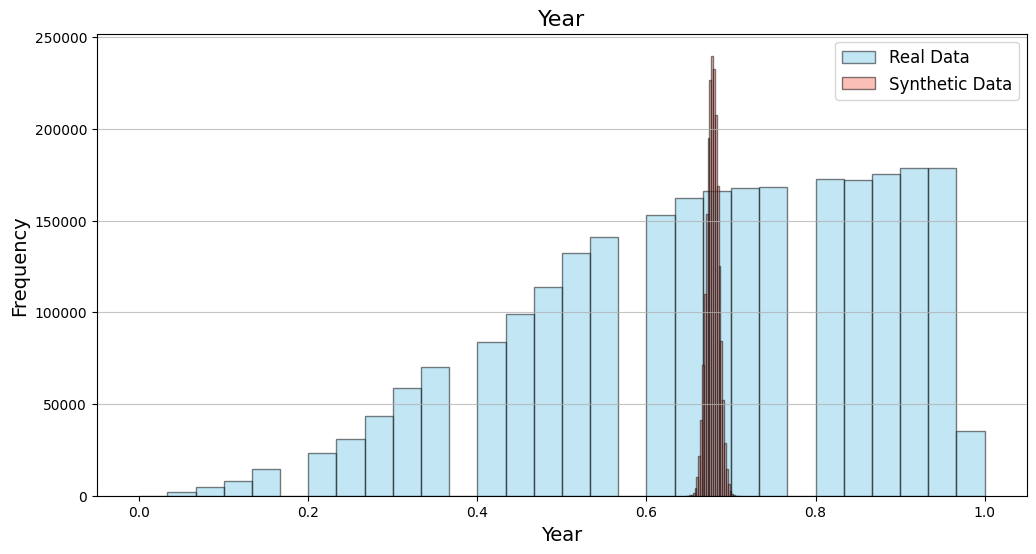

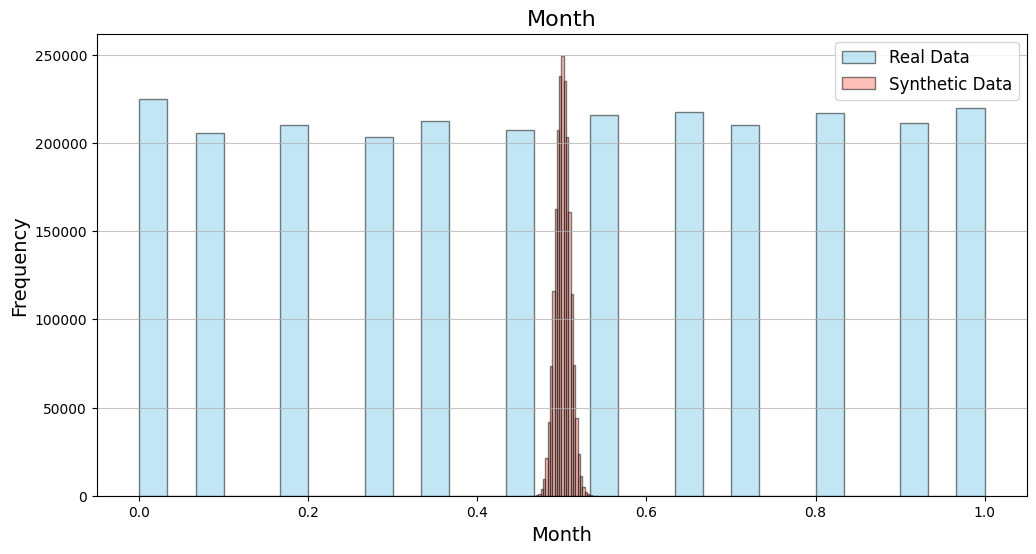

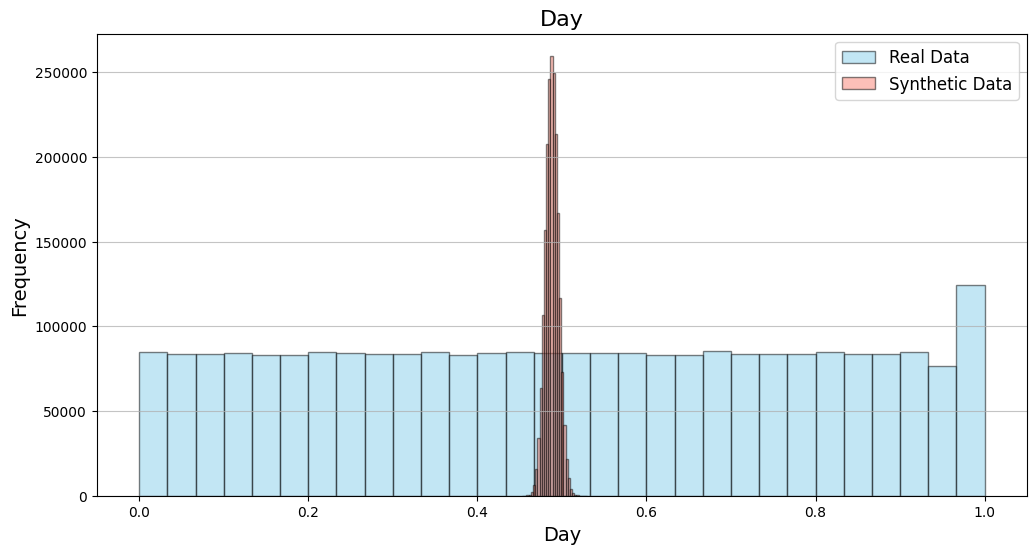

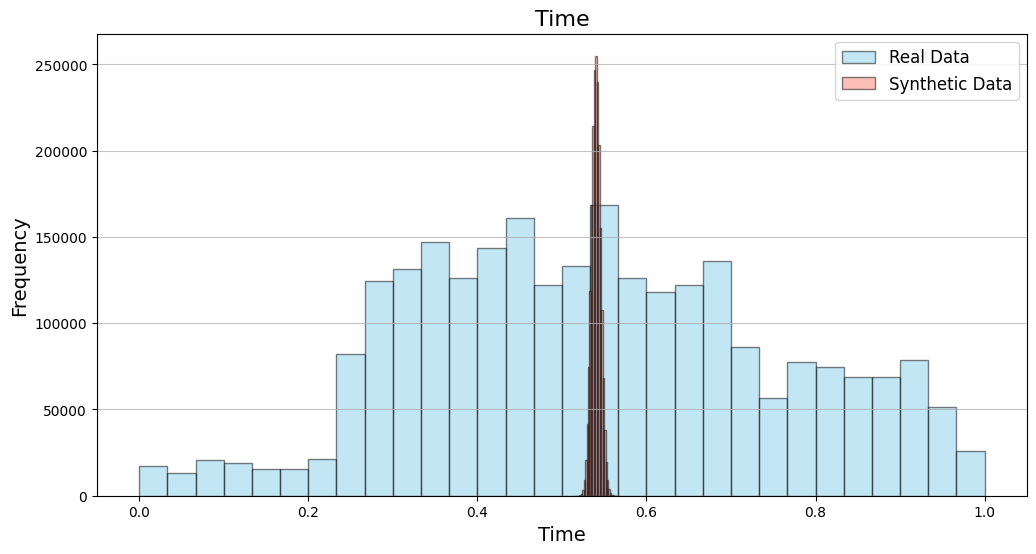

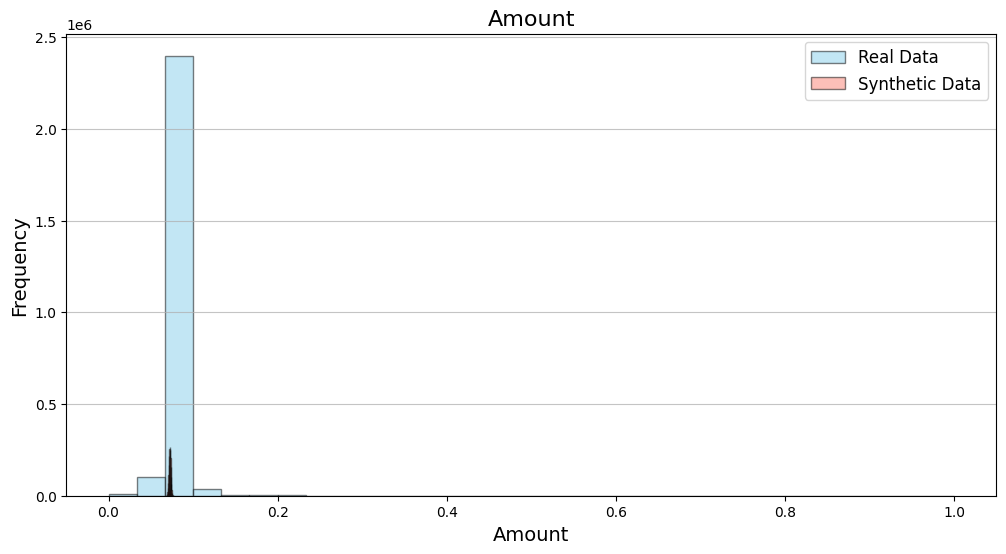

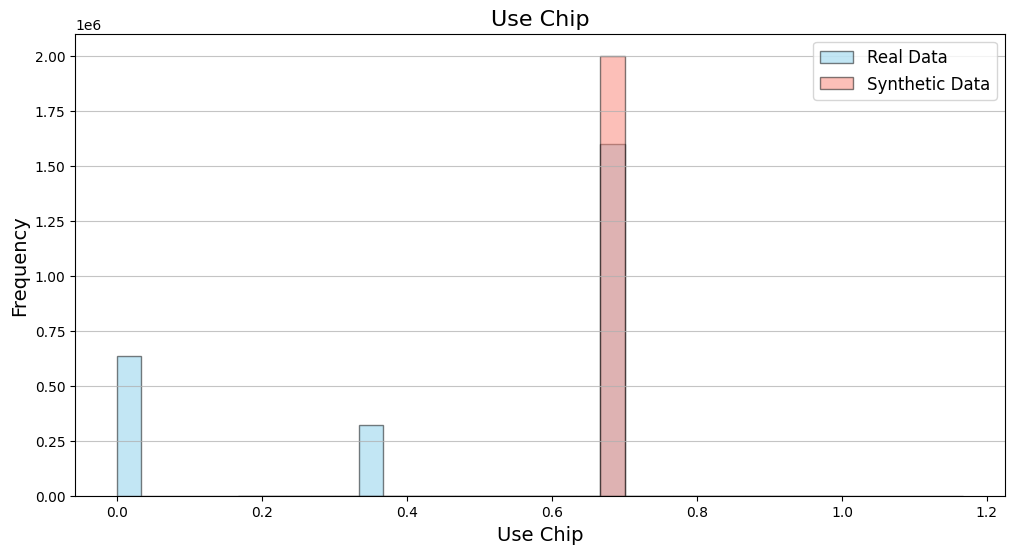

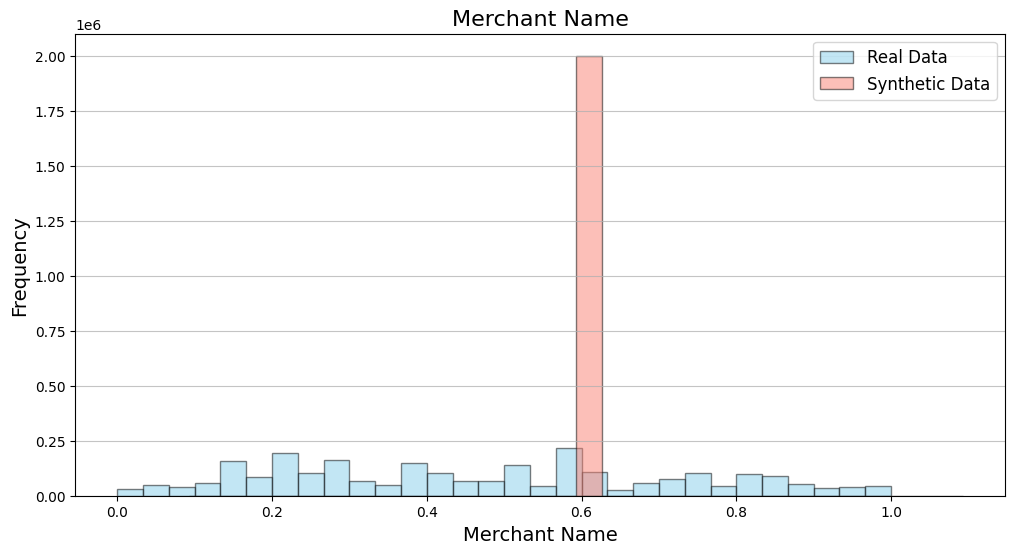

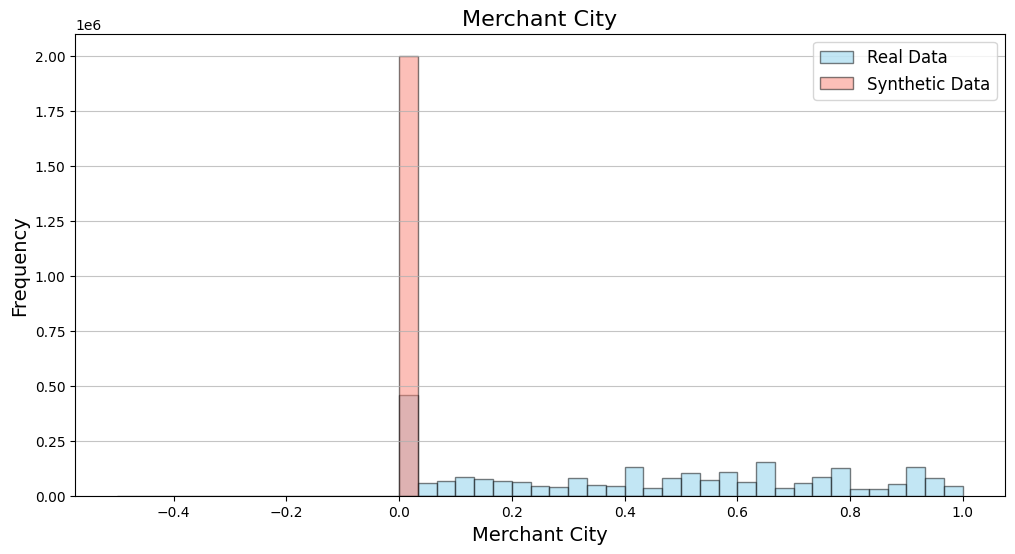

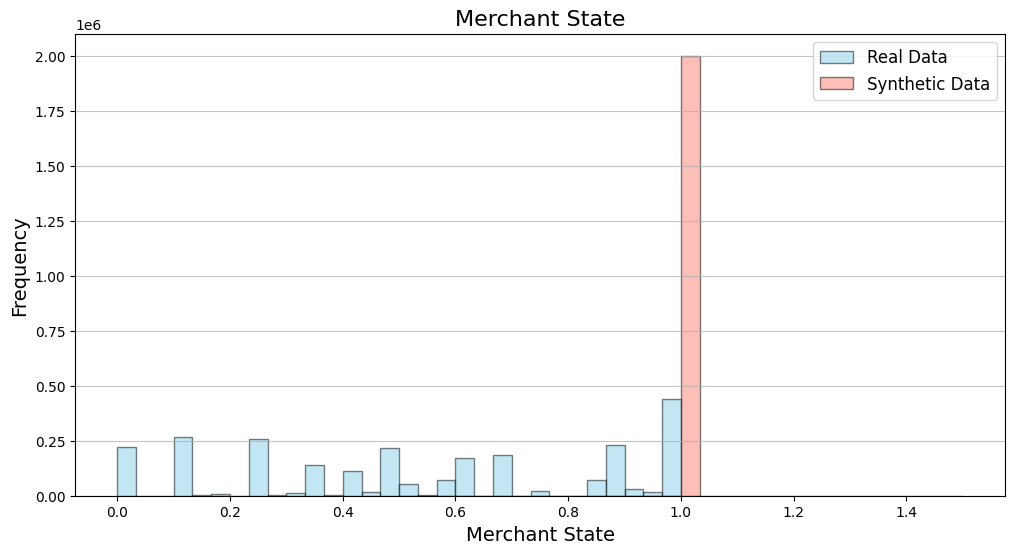

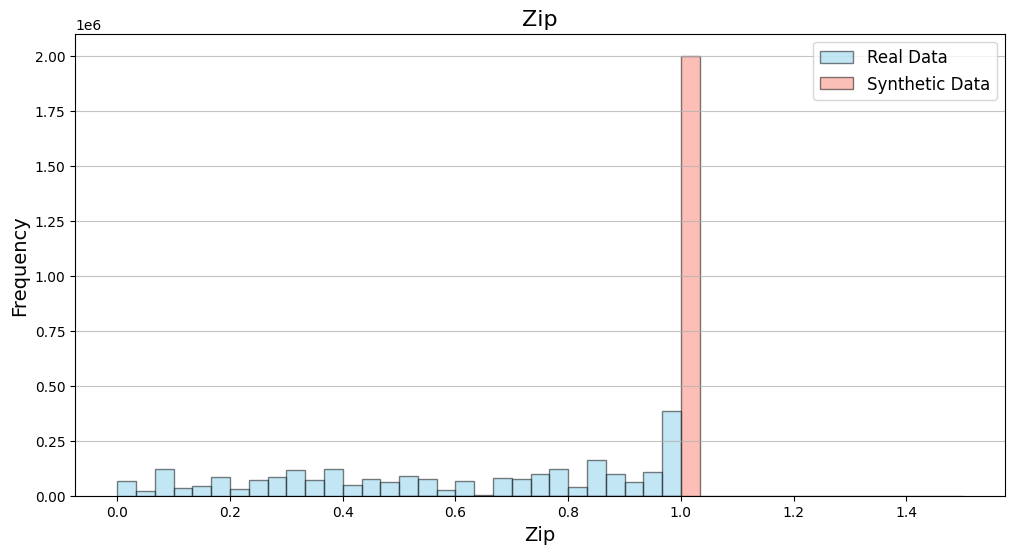

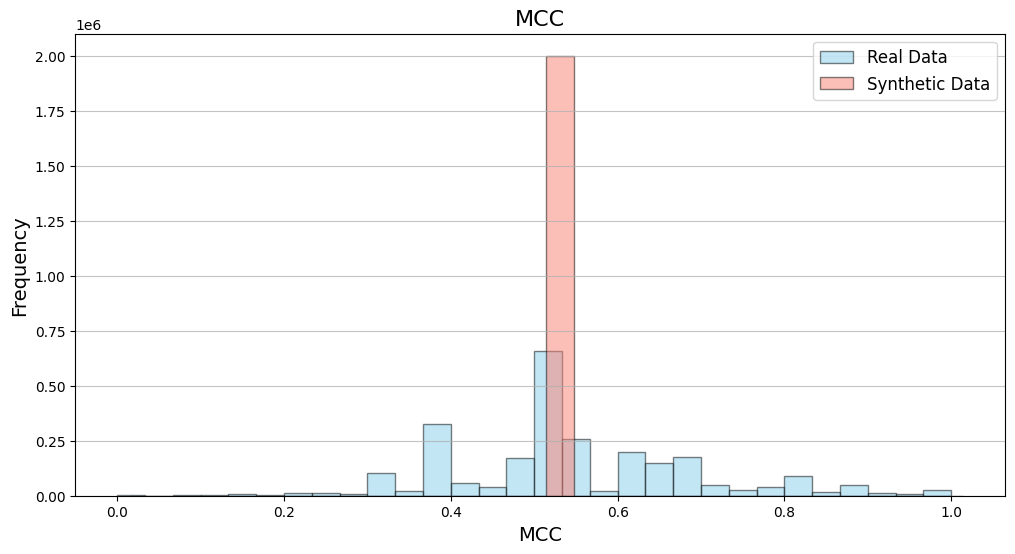

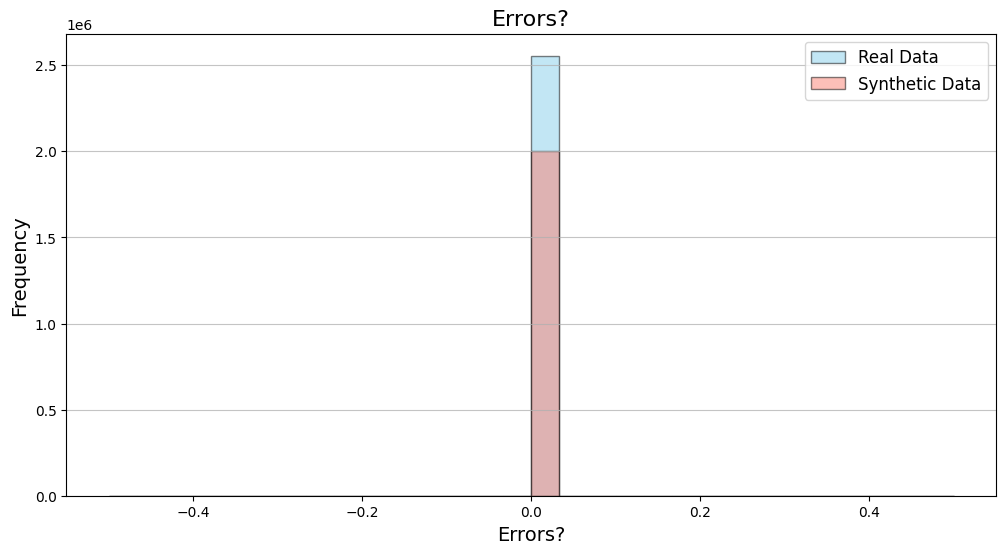

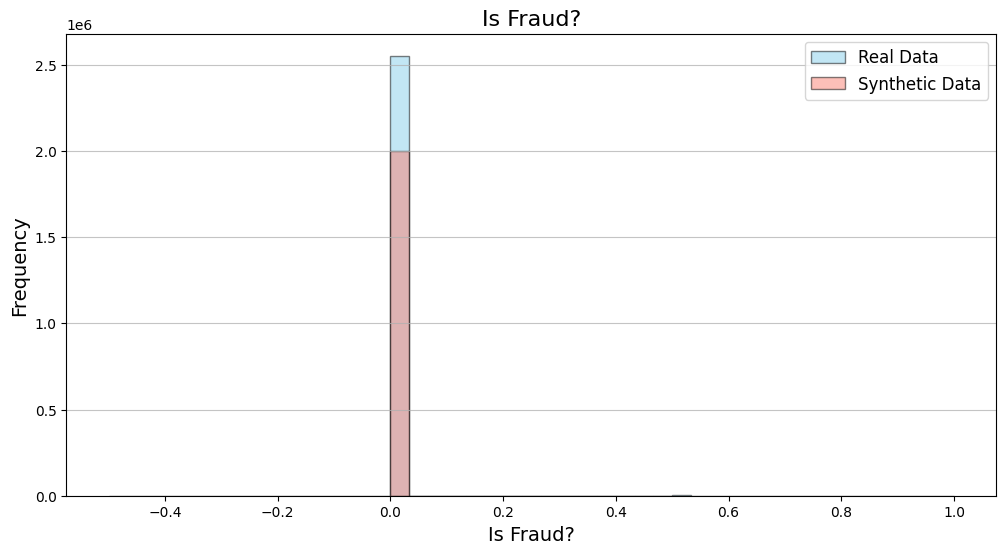

KS statistic for User: 0.8052, p-value: 0.0000
KS statistic for Card: 0.6074, p-value: 0.0000
KS statistic for Year: 0.4885, p-value: 0.0000
KS statistic for Month: 0.5055, p-value: 0.0000
KS statistic for Day: 0.4910, p-value: 0.0000
KS statistic for Time: 0.4904, p-value: 0.0000
KS statistic for Amount: 0.3484, p-value: 0.0000
KS statistic for Use Chip: 0.3744, p-value: 0.0000
KS statistic for Merchant Name: 0.6278, p-value: 0.0000
KS statistic for Merchant City: 0.8744, p-value: 0.0000
KS statistic for Merchant State: 0.8744, p-value: 0.0000
KS statistic for Zip: 0.8676, p-value: 0.0000
KS statistic for MCC: 0.5418, p-value: 0.0000
KS statistic for Errors?: 0.0000, p-value: 1.0000
KS statistic for Is Fraud?: 0.0012, p-value: 0.0976


In [8]:
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# Plot 
for col in credit_card_data.columns:
    plt.figure(figsize=(12, 6))
    plt.hist(credit_card_data[col], bins=30, alpha=0.5, color='skyblue', edgecolor='black', label='Real Data')
    plt.hist(synthetic_credit_card_data[col], bins=30, alpha=0.5, color='salmon', edgecolor='black', label='Synthetic Data')
    plt.title(col, fontsize=16)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(axis='y', alpha=0.75)
    plt.legend(fontsize=12)
    plt.show()

# Calculate the KS statistic for each column
for col in credit_card_data.columns:
    ks_stat, p_value = ks_2samp(credit_card_data[col], synthetic_credit_card_data[col])
    print(f'KS statistic for {col}: {ks_stat:.4f}, p-value: {p_value:.4f}')
